# 1. Import modules and define paths

In [1]:
import os
import re
import imageio
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu, unsharp_mask, sobel, scharr, prewitt
from skimage.filters import try_all_threshold, difference_of_gaussians as dog, gaussian
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, binary_closing, square, binary_dilation, binary_erosion, area_closing, area_opening, flood
from skimage.color import label2rgb
from skimage.color import rgb2gray
from skimage import exposure
from skimage.morphology import ball, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from scipy import signal
import scipy.fft as fft
from scipy.fft import fft2, fftshift
import random

from tqdm import tqdm
from collections.abc import Iterable
import functools

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)# definindo workdir

Mounted at /content/drive/


In [3]:
PATH_EP_ROOT = "/content/drive/MyDrive/ep_data"
PATH_DATASET_GRAY = os.path.join(PATH_EP_ROOT, "dataset_gray")
PATH_DATASET_AUG = os.path.join(PATH_EP_ROOT, "dataset_augmented")
PATH_DATASET_GROUND = os.path.join(PATH_EP_ROOT, "dataset_ground_truth")
classNames = ["tesoura", "garrafa", "chave", "prato", "livro", "sapato", "chinelo", "celular", "portacopo", "caneca"]

# 2. Import data

In [4]:
def getImagesDict(path):
  images = {}
  for dirpath, dirname, filename in os.walk(path):
      object_class = dirpath.split("/")[-1]
      for f in tqdm(filename, desc=f"{object_class}  -> "):
              if f.split(".")[-1] in ["jpg", "png", "jpeg"]:
                  path = os.path.join(dirpath, f)
                  img = imageio.imread(path)
                  images[f] = img
  return images

In [5]:
grayImagesDict = getImagesDict(PATH_DATASET_GRAY)
#imagesDict = getImagesDict(PATH_DATASET_AUG)
groundTruthImagesDict = getImagesDict(PATH_DATASET_GROUND)

dataset_gray  -> : 0it [00:00, ?it/s]
chave  -> : 100%|██████████| 144/144 [00:01<00:00, 73.61it/s] 
dataset_ground_truth  -> : 0it [00:00, ?it/s]
chave  -> : 100%|██████████| 22/22 [00:05<00:00,  4.30it/s]


In [6]:
def getOriginalGroundTruthDict(imagesDict, groundTruthImageDict):
  images = {}
  for key in groundTruthImageDict.keys():
    filename = re.sub("_[a-zA-Z]+\.png", ".png", key)
    if filename in imagesDict:
      images[filename] = imagesDict[filename]
  return images

originalGroundTruthImagesDict = getOriginalGroundTruthDict(grayImagesDict, groundTruthImagesDict)
originalGroundTruthImagesList = list(originalGroundTruthImagesDict.values())

# 3. Utils

### 3.1 Plotting function

In [7]:
def plot(image, title = ""):
  fig, ax = plt.subplots(figsize=(5, 3))
  ax.imshow(image, cmap = "gray")
  ax.set_axis_off()
  plt.tight_layout()
  plt.title(title)
  plt.show()

#### 3.2 Bounding Box class

In [8]:
from skimage.draw import rectangle
class BoundingBox(object):
  """ Bounding box class
  """
  def __init__(self):
    
    self.min_x, self.max_x = None, None
    self.min_y, self.max_y = None, None
    self.shape = None
  
  def update(self, image):
    """ Extract bounding box for binary image
    """
    
    coordinates = np.argwhere(image.astype("bool") == 1)  
    #min_x, max_x, min_y, max_y = 255, 0, 255, 0
    #for coord in coordinates:
    self.min_y, self.min_x = coordinates.min(axis = 0)
    self.max_y, self.max_x = coordinates.max(axis = 0)
    self.shape = image.shape

  def get_bbox_image(self):
    if self.shape != None:
      rows, cols = rectangle(start = (self.min_y, self.min_x), 
                            end = (self.max_y, self.max_x), 
                            shape = self.shape)
      bbox_image = np.zeros(self.shape).astype("bool")
      bbox_image[rows, cols] = True
      return bbox_image
    else:
      return None

  def get_area(self):
    return (self.max_y - self.min_y)*(self.max_x - self.min_x)

  def draw_bbox_border(self, color = "red", fill = False):
    """ Returns a matplotlib rectangle for drawing
    """
    plt_rect = mpatches.Rectangle((self.min_x, self.min_y), 
                                  self.max_x - self.min_x, 
                                  self.max_y - self.min_y,
                                  fill = fill, edgecolor = color, 
                                  linewidth=2)
    
    return plt_rect

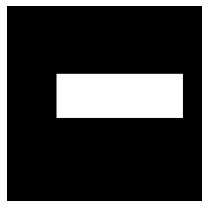

In [9]:
bbox = BoundingBox()
bbox.update(list(groundTruthImagesDict.values())[0])
plot(bbox.get_bbox_image())

# 4. Segmentation attempt BETQF

## 4.1 Segmentation method

In [10]:
from scipy.ndimage.morphology import binary_fill_holes
def betqf(image, blur_window_size = 0, edge_filter = sobel, 
          thrshold_method = threshold_otsu, quantile = 0.99, 
          flood_connectivity = ball(10), n_random_seeds = 10, 
          plot_comparison = True):
  """ Segmentation Blur-Edge-Threshold-Quantile-Flood
  
  Parameters
  -----------
  preguiça :P

  Returns
  -----------

  image_segmented: np.array (2D)
    binary segmented image
  bbox: tuple
  A tuple with 4 elements containg the bounding box 
  coodirnates: (minimum_x, maximum_x, minimum_y, maximum_y)
  """
  if blur_window_size == 0 :
    image_edge = edge_filter(image)    
  else:
    # Blurring using uniform filter
    image_edge = edge_filter(ndi.uniform_filter(image, size = blur_window_size))    
  
  thr = thrshold_method(image_edge)
  image_thr = image_edge > thr
  image_quantile = image_edge >= np.quantile(image_edge, quantile)
  
  quantiles_coordinates = list(map(tuple, np.argwhere(image_quantile == 1)))
  random.shuffle(quantiles_coordinates)
  random_seed_points = quantiles_coordinates[0:(max(n_random_seeds, len(quantiles_coordinates) - 1)) ]
  image_segmented = np.logical_or(image_quantile, flood(image_thr, random_seed_points[0], connectivity=3))
  
  for i in range(1, min(n_random_seeds, len(random_seed_points) - 1) ):
    image_segmented = np.logical_or(image_segmented, flood(image_thr, random_seed_points[i], connectivity=3))
  
  if plot_comparison:
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    ax[0, 0].imshow(image, cmap = "gray")
    ax[0, 0].set_title("Original with bbox")
    ax[0, 0].set_axis_off()
    bbox = BoundingBox()
    bbox.update(image_segmented)
    ax[0, 0].add_patch(bbox.draw_bbox_border())
    ax[0, 1].imshow(image_edge, cmap = "gray")
    ax[0, 1].set_title("Edge")      
    ax[0, 1].set_axis_off()
    ax[1, 0].imshow(image_quantile, cmap = "gray")
    ax[1, 0].set_title(f"Quantile-q{quantile}")
    ax[1, 0].set_axis_off()
    ax[1, 1].imshow(image_segmented, cmap = "gray")
    ax[1, 1].set_title("Flooded")                  
    ax[1, 1].set_axis_off()
    plt.tight_layout()
    plt.show()      
    
  return image_segmented

def fill_segmentation_interior(image_segmented, square_size = 9):
  image_with_interior = binary_closing(image_segmented, square(square_size))
  image_with_interior = ndi.binary_fill_holes(image_with_interior)
  return image_with_interior

## 4.2 Segmentation Tests

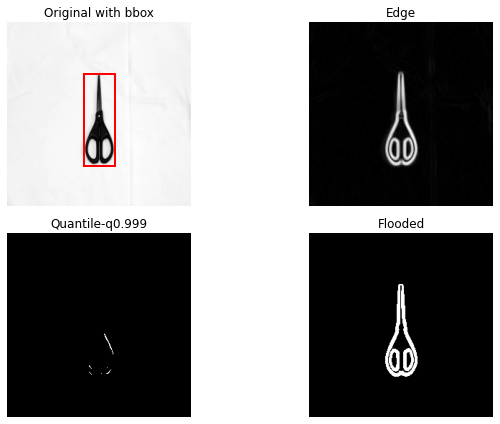

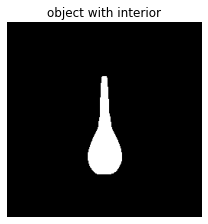

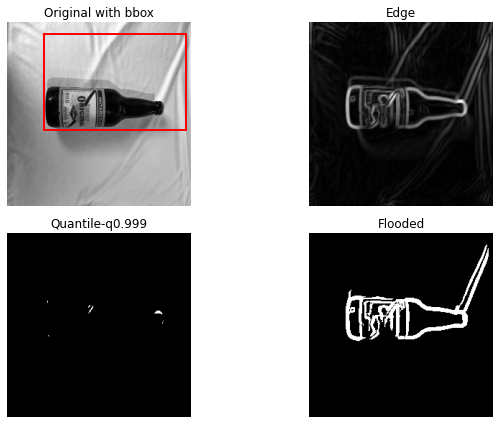

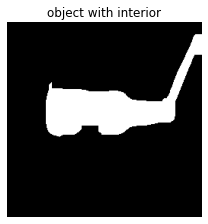

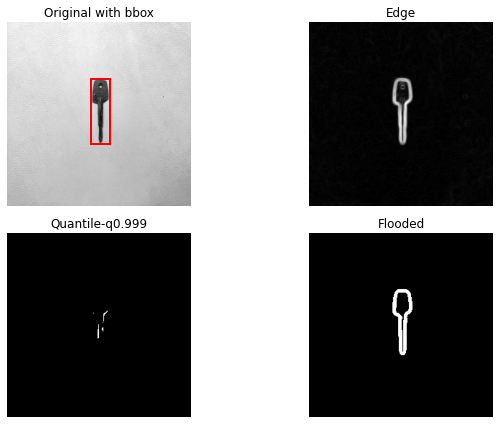

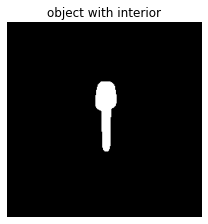

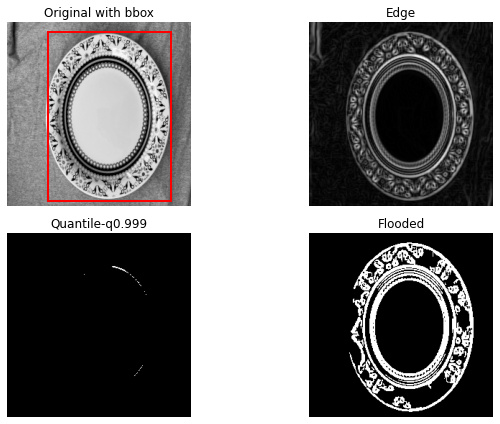

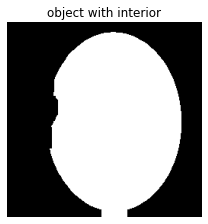

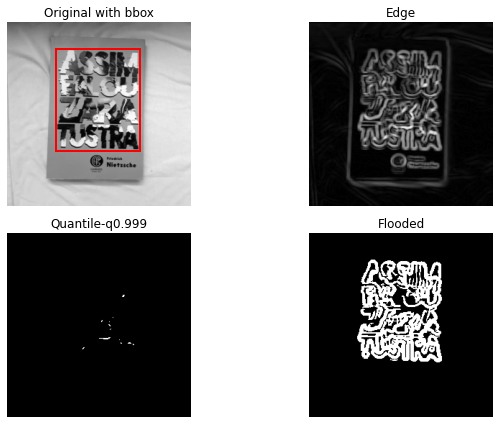

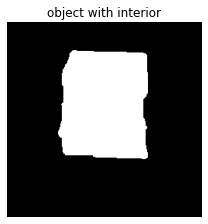

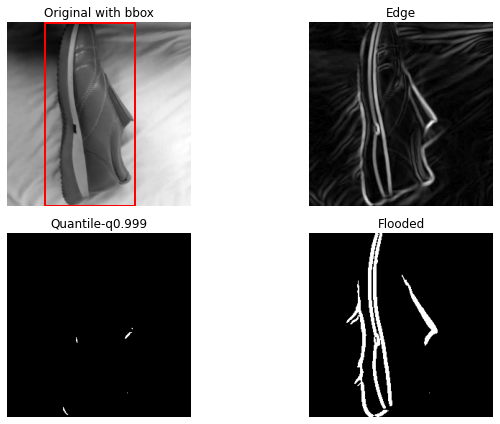

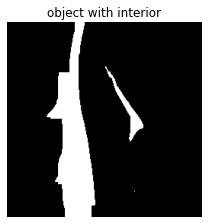

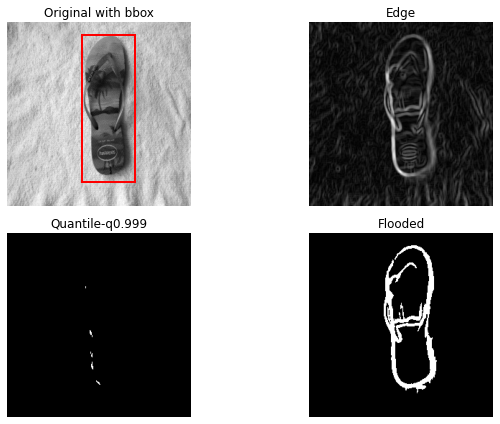

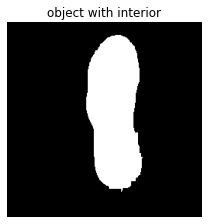

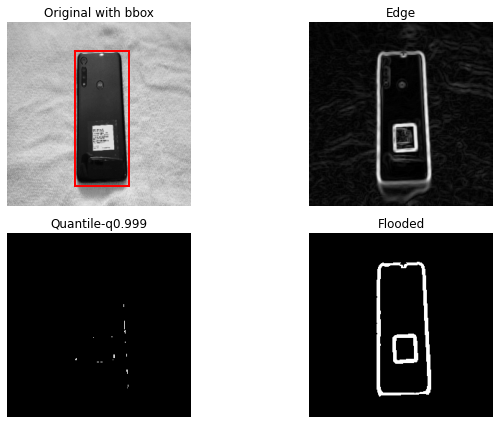

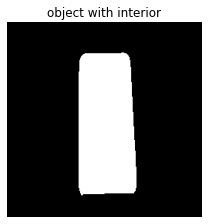

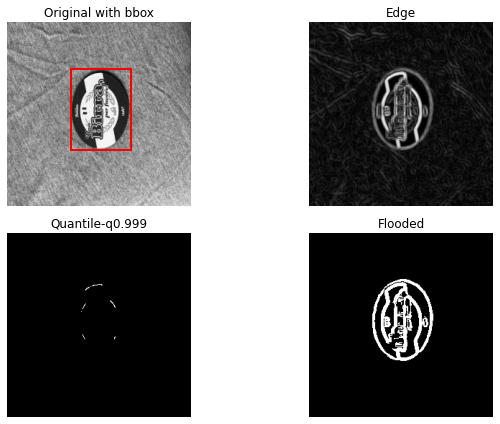

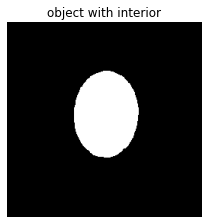

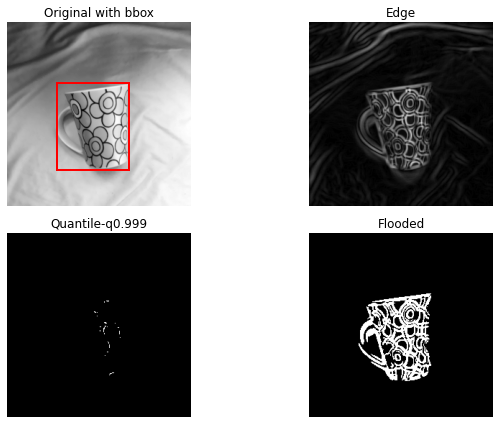

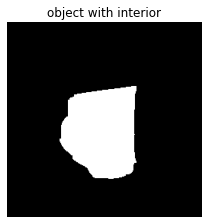

In [ ]:
for className in classNames:
  filename = f"{className}_obj1_p1_di_f1.png"
  if (filename not in grayImagesDict):
    print("Not found: ", filename)
    continue
  image_segmented = betqf(grayImagesDict[filename], 5, quantile = 0.999)
  image_with_interior = fill_segmentation_interior(image_segmented, 20)
  plot(image_with_interior, "object with interior")
  

## 5. Bounding Box Evaluation

### 5.1 auxiliar function for table metric printing

In [16]:
from tabulate import tabulate
def print_metric_table(metric_dict, return_table = False):
  """ Prints a table stratitying the average of the metric stratified by object
  and light

  Parameters
  ----------
  metric_dict: built-in dict
  The keys must be the image name, the values are the metric value for that 
  image


  """
  ### Setup dictionaries
  #--
  light_names = ["de", "di", "ne", "ni"]
  table_dict_obj = {}
  table_dict_light = {}
  total = []
  for light in light_names:
    table_dict_light[light] = []
  for obj_class in classNames:
    table_dict_obj[obj_class] = []    
  table_dict = {}
  for obj_class in classNames:
    table_dict[obj_class] = {}
    for light in light_names:
      table_dict[obj_class][light] = []
  #--

  ### Fill dictionaries
  #--
  for key in metric_dict.keys():
    obj_class, _, _, light, _ = key.split("_")
    metric_value = metric_dict[key]
    table_dict[obj_class][light].append(metric_value)
    table_dict_obj[obj_class].append(metric_value)
    table_dict_light[light].append(metric_value)
    total.append(metric_value)
  #--


  ### Creates table
  def compute_mean(score):
    if len(score) == 0:
      return np.NAN
    else:
      return round(np.mean(score), 3)

  table = [["Obj", "de", "di", "ne", "ni", "TOTAL"]]
  for obj_class in classNames:
    row = [obj_class]
    for light in light_names:
      row.append(compute_mean(table_dict[obj_class][light]))
    row.append(compute_mean(table_dict_obj[obj_class]))

    table.append(row)
  row = ["TOTAL"]
  for light in light_names:
    row.append(compute_mean(table_dict_light[light]))
  row.append(compute_mean(total))
  table.append(row)
  print(tabulate(table, tablefmt = "latex"))
  if return_table:
    return table


from tabulate import tabulate
def print_metric_table_fundo(metric_dict, return_table = False):
  """ Prints a table stratitying the average of the metric stratified by object
  and light

  Parameters
  ----------
  metric_dict: built-in dict
  The keys must be the image name, the values are the metric value for that 
  image


  """
  ### Setup dictionaries
  #--
  bg_names = ["f1", "f2", "f3"]
  table_dict_obj = {}
  table_dict_bg = {}
  total = []
  for bg in bg_names:
    table_dict_bg[bg] = []
  for obj_class in classNames:
    table_dict_obj[obj_class] = []    
  table_dict = {}
  for obj_class in classNames:
    table_dict[obj_class] = {}
    for bg in bg_names:
      table_dict[obj_class][bg] = []
  #--

  ### Fill dictionaries
  #--
  for key in metric_dict.keys():
    obj_class, _, _, _, bg = key.split("_")
    bg = bg.split(".")[0]
    metric_value = metric_dict[key]
    table_dict[obj_class][bg].append(metric_value)
    table_dict_obj[obj_class].append(metric_value)
    table_dict_bg[bg].append(metric_value)
    total.append(metric_value)
  #--


  ### Creates table
  def compute_mean(score):
    if len(score) == 0:
      return np.NAN
    else:
      return round(np.mean(score), 3)

  table = [["Obj", "f1", "f2", "f3", "TOTAL"]]
  for obj_class in classNames:
    row = [obj_class]
    for bg in bg_names:
      row.append(compute_mean(table_dict[obj_class][bg]))
    row.append(compute_mean(table_dict_obj[obj_class]))

    table.append(row)
  row = ["TOTAL"]
  for bg in bg_names:
    row.append(compute_mean(table_dict_bg[bg]))
  row.append(compute_mean(total))
  table.append(row)
  print(tabulate(table, tablefmt = "latex"))
  if return_table:
    return table

### 5.2 Defines the metrics and evaluations

In [13]:
def fast_jaccard(bbox1, bbox2):
  """ Computes jaccard index without requiring the images
  """

  bbox_inter = BoundingBox()
  bbox_inter.min_x = max(bbox1.min_x, bbox2.min_x)
  bbox_inter.min_y = max(bbox1.min_y, bbox2.min_y)
  bbox_inter.max_x = min(bbox1.max_x, bbox2.max_x)
  bbox_inter.max_y = min(bbox1.max_y, bbox2.max_y)
  area_intersection = bbox_inter.get_area()
  area_union = bbox1.get_area() + bbox2.get_area() - area_intersection
  return area_intersection/area_union

def fast_dice(bbox1, bbox2):
  """ Computes the dice score without requiring the images
  """

  bbox_inter = BoundingBox()
  bbox_inter.min_x = max(bbox1.min_x, bbox2.min_x)
  bbox_inter.min_y = max(bbox1.min_y, bbox2.min_y)
  bbox_inter.max_x = min(bbox1.max_x, bbox2.max_x)
  bbox_inter.max_y = min(bbox1.max_y, bbox2.max_y)
  area_intersection = bbox_inter.get_area()
  sum_of_areas = bbox1.get_area() + bbox2.get_area()
  return (2*area_intersection)/sum_of_areas


def evaluate_bbox(image_true, image_pred, 
                  metric = "jaccard", plot_comparison = False):
  """ Evaluates the bouding boxes using jaccard index
  """
  bbox_true = BoundingBox()
  bbox_true.update(image_true)
  bbox_pred = BoundingBox()
  bbox_pred.update(image_pred)
  if metric == "jaccard":
    metric_value = fast_jaccard(bbox_true, bbox_pred)
  elif metric == "dice":
    metric_value = fast_dice(bbox_true, bbox_pred)
  else:
    raise f"Error! Metric {metric} not implemented"
  if plot_comparison:
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.imshow(image_true, cmap = "gray")
    ax.set_title(f"Green: True bbox - Red: Predicted bbox - {metric}: {round(metric_value, 3)}")
    ax.set_axis_off()
    ax.add_patch(bbox_true.draw_bbox_border(color = "green"))
    ax.add_patch(bbox_pred.draw_bbox_border(color = "red"))
    plt.show()
  return metric_value

### 5.3 Jaccard index evaluation

### testing hyperparameters

In [ ]:
train_test_size = int(0.7*len(groundTruthImagesDict.keys()))
train_set = random.sample(groundTruthImagesDict.keys(), train_test_size)
table = [["K", "q=0.95", "q=0.99", "q=0.999"]]
for blur_window_size in [0, 5, 10, 20]:
  avg_jaccard = 0
  n_imgs = 0    
  row = [str(blur_window_size)]
  for quantile in [0.95, 0.99, 0.999]:
    value_str = ""
    for n in [1, 5, 10]:
      for key in train_set:
        image_gt = groundTruthImagesDict[key]
        image_seg = betqf(originalGroundTruthImagesDict[key], blur_window_size, quantile = quantile,
                          n_random_seeds = n,
                          plot_comparison = False)
        avg_jaccard += evaluate_bbox(image_gt, image_seg, metric = "jaccard",
                                          plot_comparison = False)
        n_imgs += 1
      value_str += str(round(avg_jaccard/n_imgs, 3))
      if n != 10:
        value_str += "/"
    print(f"Average Jaccard Index {n}-{blur_window_size}-{quantile}: {round(avg_jaccard/n_imgs, 3)}")
    row.append(value_str)
  table.append(row)

Average Jaccard Index 10-0-0.95: 0.388
Average Jaccard Index 10-0-0.99: 0.496
Average Jaccard Index 10-0-0.999: 0.536
Average Jaccard Index 10-5-0.95: 0.474
Average Jaccard Index 10-5-0.99: 0.562
Average Jaccard Index 10-5-0.999: 0.58
Average Jaccard Index 10-10-0.95: 0.528
Average Jaccard Index 10-10-0.99: 0.578
Average Jaccard Index 10-10-0.999: 0.589
Average Jaccard Index 10-20-0.95: 0.544
Average Jaccard Index 10-20-0.99: 0.565
Average Jaccard Index 10-20-0.999: 0.569


In [ ]:
table

[['K', 'q=0.95', 'q=0.99', 'q=0.999'],
 ['0', '0.402/0.395/0.388', '0.443/0.475/0.496', '0.512/0.526/0.536'],
 ['5', '0.492/0.482/0.474', '0.518/0.544/0.562', '0.569/0.574/0.58'],
 ['10', '0.541/0.535/0.528', '0.553/0.567/0.578', '0.582/0.586/0.589'],
 ['20', '0.548/0.547/0.544', '0.554/0.561/0.565', '0.567/0.568/0.569']]

In [ ]:
print(tabulate(table, tablefmt = "latex"))

\begin{tabular}{llll}
\hline
 K  & q=0.95            & q=0.99            & q=0.999           \\
 0  & 0.402/0.395/0.388 & 0.443/0.475/0.496 & 0.512/0.526/0.536 \\
 5  & 0.492/0.482/0.474 & 0.518/0.544/0.562 & 0.569/0.574/0.58  \\
 10 & 0.541/0.535/0.528 & 0.553/0.567/0.578 & 0.582/0.586/0.589 \\
 20 & 0.548/0.547/0.544 & 0.554/0.561/0.565 & 0.567/0.568/0.569 \\
\hline
\end{tabular}


In [17]:
avg_jaccard = 0
n_imgs = 0
i = 0
jaccard_dict = {}
for key in groundTruthImagesDict.keys():
  image_gt = groundTruthImagesDict[key]
  image_seg = betqf(originalGroundTruthImagesDict[key], 10, quantile = 0.999,
                    n_random_seeds=10,
                    plot_comparison = False)
  jaccard_dict[key] = evaluate_bbox(image_gt, image_seg, metric = "jaccard",
                                    plot_comparison = (key.split("_")[0] == "chave")*(i < 0))
  avg_jaccard += jaccard_dict[key] 
  n_imgs += 1
  if key.split("_")[0] == "chave":
    i += 1
print(f"Average Jaccard Index: {avg_jaccard/n_imgs}")

Average Jaccard Index: 0.6262903951254551


In [18]:
print_metric_table_fundo(jaccard_dict)

\begin{tabular}{lllll}
\hline
 Obj       & f1    & f2    & f3    & TOTAL \\
 tesoura   & 0.706 & 0.659 & 0.061 & 0.504 \\
 garrafa   & 0.84  & 0.51  & 0.678 & 0.661 \\
 chave     & 0.699 & 0.718 & 0.278 & 0.57  \\
 prato     & 0.729 & 0.916 & 0.704 & 0.78  \\
 livro     & 0.693 & 0.82  & 0.599 & 0.705 \\
 sapato    & 0.757 & 0.834 & 0.556 & 0.717 \\
 chinelo   & 0.81  & 0.504 & 0.629 & 0.648 \\
 celular   & 0.561 & 0.401 & 0.51  & 0.491 \\
 portacopo & 0.801 & 0.801 & 0.326 & 0.542 \\
 caneca    & 0.632 & 0.87  & 0.278 & 0.624 \\
 TOTAL     & 0.714 & 0.71  & 0.477 & 0.626 \\
\hline
\end{tabular}


### 5.4 Dice score evaluation

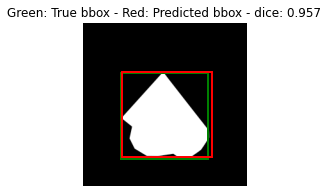

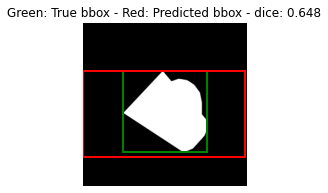

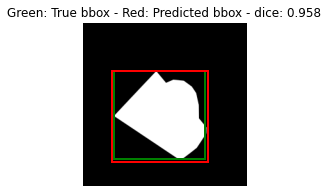

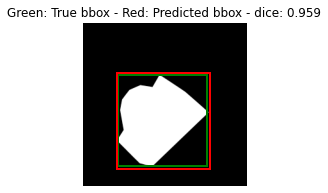

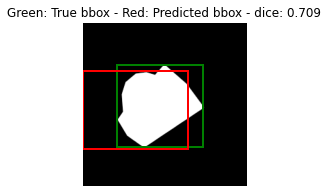

Average dice score: 0.7226681873928588


In [19]:
avg_dice = 0
n_imgs = 0
dice_dict = {}
i = 0
for key in groundTruthImagesDict.keys():
  image_gt = groundTruthImagesDict[key]
  image_seg = betqf(originalGroundTruthImagesDict[key], 10,quantile = 0.999,n_random_seeds = 10, plot_comparison = False)
  dice_dict[key] = evaluate_bbox(image_gt, image_seg, metric = "dice",
                                    plot_comparison = (key.split("_")[0] == "caneca")*(i < 5) )
  avg_dice += dice_dict[key] 
  n_imgs += 1
  if key.split("_")[0] == "caneca":
    i += 1
print(f"Average dice score: {avg_dice/n_imgs}")

In [20]:
print_metric_table_fundo(dice_dict)

\begin{tabular}{lllll}
\hline
 Obj       & f1    & f2    & f3    & TOTAL \\
 tesoura   & 0.826 & 0.774 & 0.118 & 0.604 \\
 garrafa   & 0.911 & 0.635 & 0.792 & 0.767 \\
 chave     & 0.82  & 0.826 & 0.352 & 0.673 \\
 prato     & 0.794 & 0.936 & 0.788 & 0.838 \\
 livro     & 0.777 & 0.874 & 0.715 & 0.79  \\
 sapato    & 0.815 & 0.905 & 0.704 & 0.811 \\
 chinelo   & 0.894 & 0.621 & 0.757 & 0.757 \\
 celular   & 0.602 & 0.512 & 0.609 & 0.575 \\
 portacopo & 0.889 & 0.889 & 0.494 & 0.673 \\
 caneca    & 0.748 & 0.929 & 0.397 & 0.718 \\
 TOTAL     & 0.801 & 0.795 & 0.592 & 0.723 \\
\hline
\end{tabular}


## 6. Segmentation evaluation
#### We now compare the segmentation directly instead of the bounding boxes

### 6.1 Define metrics

In [21]:
def compute_jaccard(img1, img2):
  """ Computes jaccard index on images
  """

  area_union = np.sum(np.logical_or(img1, img2))
  area_intersection = np.sum(np.logical_and(img1, img2))
  return area_intersection/area_union

def compute_dice(img1, img2):
  """ Computes the dice score on images
  """

  area_img1 = np.sum(img1.astype("bool"))
  area_img2 = np.sum(img2.astype("bool"))
  area_intersection = np.sum(np.logical_and(img1, img2))
  sum_of_areas = area_img1 + area_img2
  return (2*area_intersection)/sum_of_areas


def evaluate_segmentation(image_true, image_pred, 
                          metric = "jaccard", plot_comparison = False):
  """ Evaluates the bouding boxes using jaccard index
  """
  if metric == "jaccard":
    metric_value = compute_jaccard(image_true, image_pred)
  elif metric == "dice":
    metric_value = compute_dice(image_true, image_pred)
  else:
    raise f"Error! Metric {metric} not implemented"
  if plot_comparison:
    fig, ax = plt.subplots(1, 2, figsize=(5, 3))
    ax[0].imshow(image_true, cmap = "gray")
    ax[0].set_title(f"True")
    ax[0].set_axis_off()
    ax[1].imshow(image_pred, cmap = "gray")
    ax[1].set_title(f"Predicted - {metric}: {round(metric_value, 3)}")
    ax[1].set_axis_off()    
    plt.show()
  return metric_value

### 6.2 Jaccard segmentation evaluation

In [ ]:
train_test_size = int(0.7*len(groundTruthImagesDict.keys()))
train_set = random.sample(groundTruthImagesDict.keys(), train_test_size)
table = [["K", "q=0.95", "q=0.99", "q=0.999"]]
for blur_window_size in [0, 5, 10, 20]:
  avg_jaccard = 0
  n_imgs = 0    
  row = [str(blur_window_size)]
  for quantile in [0.95, 0.99, 0.999]:
    value_str = ""
    for n in [1, 5, 10]:
      for key in train_set:
        image_gt = groundTruthImagesDict[key]
        image_seg = betqf(originalGroundTruthImagesDict[key], blur_window_size, quantile = quantile,
                          n_random_seeds = n,
                          plot_comparison = False)
        image_with_interior = fill_segmentation_interior(image_seg)
        avg_jaccard += evaluate_segmentation(image_gt, image_with_interior, 
                                            metric = "jaccard",
                                          plot_comparison = False)
        n_imgs += 1
      value_str += str(round(avg_jaccard/n_imgs, 3))
      if n != 10:
        value_str += "/"
    print(f"Average Jaccard Index {n}-{blur_window_size}-{quantile}: {round(avg_jaccard/n_imgs, 3)}")
    row.append(value_str)
  table.append(row)

Average Jaccard Index 10-0-0.95: 0.328
Average Jaccard Index 10-0-0.99: 0.39
Average Jaccard Index 10-0-0.999: 0.404
Average Jaccard Index 10-5-0.95: 0.401
Average Jaccard Index 10-5-0.99: 0.427
Average Jaccard Index 10-5-0.999: 0.433
Average Jaccard Index 10-10-0.95: 0.404
Average Jaccard Index 10-10-0.99: 0.427
Average Jaccard Index 10-10-0.999: 0.432
Average Jaccard Index 10-20-0.95: 0.44
Average Jaccard Index 10-20-0.99: 0.445
Average Jaccard Index 10-20-0.999: 0.447


In [ ]:
print(tabulate(table, tablefmt = "latex"))

\begin{tabular}{llll}
\hline
 K  & q=0.95            & q=0.99            & q=0.999           \\
 0  & 0.377/0.347/0.328 & 0.35/0.375/0.39   & 0.392/0.398/0.404 \\
 5  & 0.41/0.405/0.401  & 0.406/0.418/0.427 & 0.427/0.43/0.433  \\
 10 & 0.401/0.404/0.404 & 0.409/0.419/0.427 & 0.427/0.429/0.432 \\
 20 & 0.437/0.438/0.44  & 0.441/0.443/0.445 & 0.446/0.446/0.447 \\
\hline
\end{tabular}


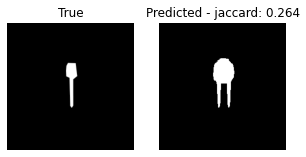

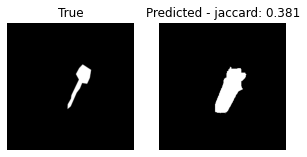

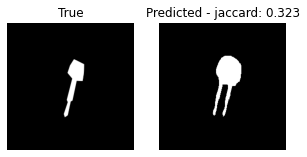

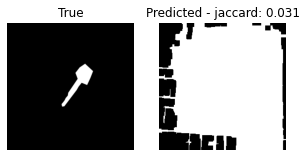

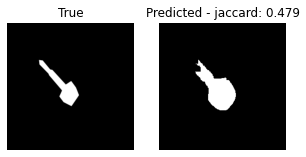

Average Jaccard Index: 0.44865365150001985


In [22]:
avg_jaccard = 0
n_imgs = 0
i = 0
jaccard_dict = {}
for key in groundTruthImagesDict.keys():
  image_gt = groundTruthImagesDict[key]
  image_seg = betqf(originalGroundTruthImagesDict[key], 20, quantile = 0.999,
                    n_random_seeds = 10,
                    plot_comparison = False)
  image_with_interior = fill_segmentation_interior(image_seg)
  jaccard_dict[key] = evaluate_segmentation(image_gt, image_with_interior, 
                                            metric = "jaccard",
                                            plot_comparison = (key.split("_")[0] == "chave")*(i < 5) )
  avg_jaccard += jaccard_dict[key] 
  n_imgs += 1
  if (key.split("_")[0] == "chave"):
    i += 1
print(f"Average Jaccard Index: {avg_jaccard/n_imgs}")

In [23]:
print_metric_table_fundo(jaccard_dict)

\begin{tabular}{lllll}
\hline
 Obj       & f1    & f2    & f3    & TOTAL \\
 tesoura   & 0.332 & 0.251 & 0.01  & 0.209 \\
 garrafa   & 0.569 & 0.533 & 0.574 & 0.558 \\
 chave     & 0.472 & 0.403 & 0.195 & 0.365 \\
 prato     & 0.481 & 0.652 & 0.466 & 0.531 \\
 livro     & 0.356 & 0.625 & 0.331 & 0.446 \\
 sapato    & 0.493 & 0.538 & 0.361 & 0.464 \\
 chinelo   & 0.615 & 0.55  & 0.438 & 0.534 \\
 celular   & 0.378 & 0.329 & 0.617 & 0.441 \\
 portacopo & 0.688 & 0.703 & 0.286 & 0.473 \\
 caneca    & 0.42  & 0.676 & 0.163 & 0.448 \\
 TOTAL     & 0.469 & 0.531 & 0.354 & 0.449 \\
\hline
\end{tabular}


### 6.3 Dice segmentation evaluation

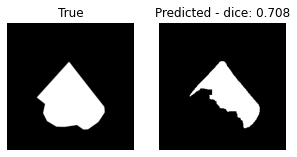

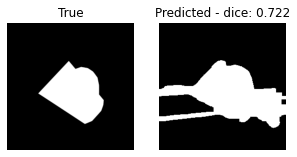

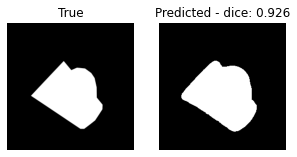

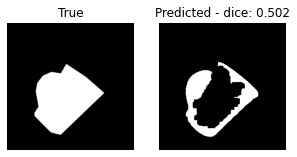

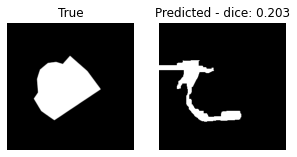

Average dice score: 0.5725467667359576


In [24]:
avg_dice = 0
n_imgs = 0
i = 0
dice_dict = {}
for key in groundTruthImagesDict.keys():
  image_gt = groundTruthImagesDict[key]
  image_seg = betqf(originalGroundTruthImagesDict[key], 10, quantile = 0.999, n_random_seeds = 20, plot_comparison = False)
  image_with_interior = fill_segmentation_interior(image_seg)  
  dice_dict[key] = evaluate_segmentation(image_gt, image_with_interior, metric = "dice",
                                    plot_comparison = (key.split("_")[0] == "caneca")*(i < 5) )
  avg_dice += dice_dict[key] 
  n_imgs += 1
  if (key.split("_")[0] == "caneca"):
    i += 1
print(f"Average dice score: {avg_dice/n_imgs}")

In [25]:
print_metric_table_fundo(dice_dict)

\begin{tabular}{lllll}
\hline
 Obj       & f1    & f2    & f3    & TOTAL \\
 tesoura   & 0.675 & 0.603 & 0.039 & 0.466 \\
 garrafa   & 0.65  & 0.677 & 0.666 & 0.666 \\
 chave     & 0.736 & 0.619 & 0.341 & 0.578 \\
 prato     & 0.388 & 0.784 & 0.663 & 0.651 \\
 livro     & 0.478 & 0.739 & 0.411 & 0.55  \\
 sapato    & 0.514 & 0.682 & 0.431 & 0.549 \\
 chinelo   & 0.73  & 0.54  & 0.471 & 0.58  \\
 celular   & 0.428 & 0.387 & 0.601 & 0.472 \\
 portacopo & 0.892 & 0.912 & 0.511 & 0.69  \\
 caneca    & 0.659 & 0.725 & 0.189 & 0.546 \\
 TOTAL     & 0.615 & 0.665 & 0.451 & 0.573 \\
\hline
\end{tabular}


## 7. Summarize the number of items on the ground truth dataset

In [ ]:
from tabulate import tabulate
def print_gt_table(gt_filenames, return_table = False):
  """ summarise gt dataset 
  """

  ### Setup dictionaries
  #--
  light_names = ["de", "di", "ne", "ni"]
  table_dict_obj = {}
  table_dict_light = {}
  table_dict_n_objs = {}
  total = 0
  for light in light_names:
    table_dict_light[light] = 0
  for obj_class in classNames:
    table_dict_obj[obj_class] = 0
    table_dict_n_objs[obj_class] = set()
  table_dict = {}
  for obj_class in classNames:
    table_dict[obj_class] = {}
    for light in light_names:
      table_dict[obj_class][light] = 0
  #--

  ### Fill dictionaries
  #--
  for filename in gt_filenames:
    obj_class, obj, _, light, _ = filename.split("_")
    table_dict[obj_class][light] +=1
    table_dict_obj[obj_class] += 1
    table_dict_light[light] += 1
    table_dict_n_objs[obj_class].add(obj[-1])
    total += 1
  #--

  table = [["Obj", "de", "di", "ne", "ni", "Diferentes", "TOTAL"]]
  for obj_class in classNames:
    row = [obj_class]
    for light in light_names:
      row.append(table_dict[obj_class][light])
    row.append(len(table_dict_n_objs[obj_class]))
    row.append(table_dict_obj[obj_class])

    table.append(row)
  row = ["TOTAL"]
  for light in light_names:
    row.append(table_dict_light[light])
  row.append(np.sum(list(map(len, table_dict_n_objs.values()))))
  row.append(total)
  table.append(row)
  print(tabulate(table, tablefmt='latex'))
  if return_table:
    return table

In [ ]:
print_gt_table(list(groundTruthImagesDict.keys()))

\begin{tabular}{lllllll}
\hline
 Obj       & de & di & ne & ni & Diferentes & TOTAL \\
 tesoura   & 5  & 6  & 6  & 4  & 4          & 21    \\
 garrafa   & 6  & 5  & 7  & 4  & 4          & 22    \\
 chave     & 8  & 5  & 2  & 7  & 4          & 22    \\
 prato     & 6  & 8  & 2  & 5  & 4          & 21    \\
 livro     & 7  & 8  & 7  & 5  & 4          & 27    \\
 sapato    & 4  & 13 & 4  & 5  & 4          & 26    \\
 chinelo   & 4  & 7  & 9  & 4  & 4          & 24    \\
 celular   & 10 & 7  & 4  & 3  & 4          & 24    \\
 portacopo & 3  & 8  & 5  & 6  & 3          & 22    \\
 caneca    & 9  & 9  & 4  & 5  & 4          & 27    \\
 TOTAL     & 62 & 76 & 50 & 48 & 39         & 236   \\
\hline
\end{tabular}


# 8. Creates the dataset for classification task

In [ ]:
imagesDict = getImagesDict(PATH_DATASET_AUG)

dataset_augmented  -> : 0it [00:00, ?it/s]
chave  -> : 100%|██████████| 720/720 [00:03<00:00, 234.82it/s]


In [ ]:
def parse_light(light):
  parsed_light = ""
  if light[0] == "d":
    parsed_light = "dia-"
  else:
    parsed_light = "noite-"
  parsed_light += "-"
  if light[1] == "e":
    parsed_light += "exterior"


def parse_augmented_img_columns(img_name):
  parsed_img_name = img_name.split(".")[0]
  try:
    obj, nobj, pos, light, bg, transf = parsed_img_name.split("_")[0:6]
    nobj = int(nobj[3])
    pos = int(pos[1])
    bg = int(bg[1])
    if light[0] == "d":
      parsed_light = "dia"
    else:
      parsed_light = "noite"
    if light[1] == "e":
      amb = "exterior"
    else:
      amb = "interior"
    dict_col = {"Objeto": obj,
                "Nobjeto": nobj,
                "Posicao": pos,
                "Iluminacao": parsed_light,
                "Ambiente": amb,
                "Fundo": bg,
                "Trasnformacao": transf,
                "Nome": img_name}
  except Exception as e :
    print("Error in parsing image!")
    print(f"Image name: {img_name}")
    print(e)
  return(dict_col)

In [ ]:
import pandas as pd

In [ ]:
# df_list = []
# img_list = []
# label_list = []
# bbox = BoundingBox()
# for dirpath, dirname, filename in os.walk(PATH_DATASET_AUG):
#   if dirpath != PATH_DATASET_AUG + "/":
#     for file in tqdm(filename, desc=f"{dirpath}  -> "):
#       if file.split(".")[1] in ["jpg", "png", "jpeg"]:
#         row_dict = parse_augmented_img_columns(file)
#         img = imageio.imread(os.path.join(dirpath, file))
#         #row_dict["Image"] = [img]
#         img_list.append(img)
#         image_segmented = betqf(img, 5, quantile = 0.999, plot_comparison=False)
#         bbox.update(image_segmented)
#         img_label = bbox.get_bbox_image()
#         #row_dict["ImageLabel"] = [img_label]
#         label_list.append(img_label)
#         df_list.append(row_dict)

# df = pd.DataFrame(df_list)
# print(df.head)

/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmented  -> : 0it [00:00, ?it/s]
/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmented/celular  -> : 100%|██████████| 675/675 [00:19<00:00, 34.95it/s]
/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmented/sapato  -> : 100%|██████████| 720/720 [00:23<00:00, 31.11it/s]
/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmented/chinelo  -> : 100%|██████████| 720/720 [00:23<00:00, 31.10it/s]
/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmented/caneca  -> : 100%|██████████| 720/720 [00:20<00:00, 35.74it/s]
/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmented/tesoura  -> : 100%|██████████| 720/720 [00:22<00:00, 32.23it/s]
/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmented/livro  -> : 100%|██████████| 720/720 [00:23<00:00, 30.58it/s]
/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmented/portacopo  -> : 100%|██████████| 720/720 [00:20<00:00, 35.70it/s]
/content/drive/MyDrive/EP - MAC0417 5768/dataset_augmente

<bound method NDFrame.head of        Objeto  Nobjeto  Posicao Iluminacao  Ambiente  Fundo Trasnformacao  \
0     celular        1        1        dia  exterior      2           log   
1     celular        1        1        dia  exterior      2      identity   
2     celular        1        1        dia  exterior      2           exp   
3     celular        1        1        dia  exterior      2   convolution   
4     celular        1        1        dia  exterior      2      gradient   
...       ...      ...      ...        ...       ...    ...           ...   
7150    chave        3        1        dia  exterior      2      identity   
7151    chave        3        1        dia  exterior      2           log   
7152    chave        3        1        dia  exterior      2           exp   
7153    chave        3        1        dia  exterior      2   convolution   
7154    chave        3        1        dia  exterior      2      gradient   

                                       Nome  

In [ ]:
#save_path = os.path.join(PATH_EP_ROOT, "classification_dataset.csv")
#df.to_csv(save_path, index=False)

# save imgs and labels as pkl
#from joblib import dump


In [ ]:
#dump(img_list, os.path.join(PATH_EP_ROOT, 'images.pkl'))
#dump(label_list, os.path.join(PATH_EP_ROOT, 'labels.pkl'))

['/content/drive/MyDrive/EP - MAC0417 5768/labels.pkl']

In [ ]:
#dump(label_list, os.path.join(PATH_EP_ROOT, 'labels.pkl'))

['/content/drive/MyDrive/EP - MAC0417 5768/labels.pkl']